### Convolutional Neural Network (CNN) for Processing and Classifying CIFAR-10 Images from Scratch

### Part 1 : Initial Data Processing

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(3)

Load up initial data from CIFAR-10:
* 10 classes of images (airplane, automobile, bird...)
* 6000 images per class (5000 train, 1000 test)

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

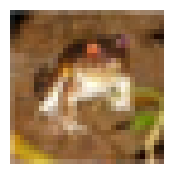

In [13]:
def load_batch_from_file(file_path):
    # load data from a CIFAR-10 batch file using pickle
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data = np.array(batch[b'data'])
    labels = np.array(batch[b'labels'])
    return data, labels

# reshape data into 3 channels of 32x32 images
data, labels = load_batch_from_file('cifar-10-batches-py/data_batch_1')
data_separated = data[0].reshape(3, 32, 32)

img = data_separated.transpose(1, 2, 0)  # (H, W, C)

# display first image for test
plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.axis("off")


Process all training and test batches from cifar-10-batches-py folder

In [38]:
def load_batches():
    X_list, Y_list = [], []

    # load training batches 1 to 5
    for i in range(1, 6):
        path = f'cifar-10-batches-py/data_batch_{i}'
        data, labels = load_batch_from_file(path)

        X_list.append(data)
        Y_list.append(labels)

    # concatenate all training batches
    X_train = np.concatenate(X_list)
    Y_train = np.concatenate(Y_list)

    # test batch
    X_test, Y_test = load_batch_from_file('cifar-10-batches-py/test_batch')

    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = load_batches()

# shapes
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)

X_train: (50000, 3072)
Y_train: (50000,)
X_test: (10000, 3072)
Y_test: (10000,)


Reshape datasets into (3, 32, 32) and normalize

In [39]:
# reshape to (N, 3, 32, 32)
X_train = X_train.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)

print("X_train reshaped:", X_train.shape)
print("X_test reshaped:", X_test.shape)

# normalize pixel values to [0, 1] and convert to float32 for precision
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

X_train reshaped: (50000, 3, 32, 32)
X_test reshaped: (10000, 3, 32, 32)


Utility functions for later. Split train into train + validation and iterate through batches during training

In [ ]:
def train_val_split(X, Y, ratio=0.1):
    """
    Split the training data into new training and validation sets.
    """
    N = len(X)
    random_indices = np.random.permutation(N)
    val_size = int(N * ratio)

    # calculate validation and new training indices
    val_i = random_indices[:val_size]
    train_i = random_indices[val_size:]

    X_val, Y_val = X[val_i], Y[val_i]
    X_train_new, Y_train_new = X[train_i], Y[train_i]

    return X_train_new, Y_train_new, X_val, Y_val


def batch_generator(X, Y, batch_size=64, random=True):
    """
    Generate batches of data from X and Y with specified batch size.
    """
    N = len(X)
    indices = np.arange(N)

    # shuffle indices
    if random:
        indices = np.random.permutation(N)

    for start in range(0, N, batch_size):
        # determine the end index of the batch, if > N, set to N
        end = min(start + batch_size, N)
        batch_indices = indices[start:end]

        # process batch one by one
        yield X[batch_indices], Y[batch_indices]


# split training data into new training and validation sets
X_train, Y_train, X_val, Y_val = train_val_split(X_train, Y_train, ratio=0.1)

print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_val:", X_val.shape)
print("Y_val:", Y_val.shape)


X_train: (45000, 3, 32, 32)
Y_train: (45000,)
X_val: (5000, 3, 32, 32)
Y_val: (5000,)


### Part 2: The Convolution Layer and Feature Extraction

Work in Progress

testImg shape: (3, 32, 32)


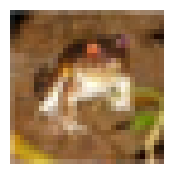

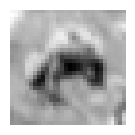

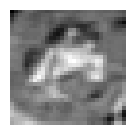

In [104]:
testImg = data_separated
print("testImg shape:", testImg.shape)  # (3, 32, 32)

def convolve(X, kernelSize = (3, 3), stride = 1, num_filters=1, padding=0):
    """
    Perform convolution on input image X with specified kernel size, stride, and depth.

    X: input image of shape (C, H, W)
    """
    # dimensions
    kH, kW = kernelSize
    C, H, W = X.shape

    if padding > 0:
        X = np.pad(X, ((0,0), (padding, padding), (padding, padding)), mode='constant')

    # initialize kernels with random values
    kernels = np.random.randn(num_filters, C, kH, kW)
    # print("kernels shape:", kernels)  # (depth, kH, kW)

    outH = (H - kH + 2 * padding) // stride + 1
    outW = (W - kW + 2 * padding) // stride + 1
    output = np.zeros((num_filters, outH, outW))

    # print(kernels.shape)

    for d in range(num_filters):
        kernel = kernels[d] # select the d-th kernel

        for i in range(outH):
            for j in range(outW):
                h1 = i * stride
                h2 = h1 + kH
                w1 = j * stride
                w2 = w1 + kW

                # perform convolution of the kernel and image region
                r = X[:, h1:h2, w1:w2]
                output[d, i, j] = np.sum(r * kernel)

    return output


featureMap = convolve(testImg, kernelSize=(3, 3), stride=1, num_filters=2)
featureMap = featureMap.transpose(1, 2, 0)

# show the original image and feature map
origImg = testImg.transpose(1, 2, 0)
plt.figure(figsize=(2, 2))
plt.imshow(origImg)
plt.axis("off")

# feature maps
for i in range(featureMap.shape[2]):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(featureMap[:, :, i], cmap='gray')
    plt.axis("off")

plt.subplots_adjust(wspace=0.2)
plt.show()

### Citation

CIFAR-10 dataset generously provided by __Alex Krizhevsky’s 2009 technical report, Learning Multiple Layers of Features from Tiny Images__